# МОиВС "Генеративные модели", 5-й модуль

# Homework 1

В этой домашней работе вам предстоит добавить к BERT'у декодерную часть и решить задачу генерации суммаризаций для текстов новостей на русском языке.

Дополнительно к этому на отличную оценку потребуется реализовать подсчет метрик качества и менее жадную стратегию выбора следующего токена для генерации.

*Мы сразу вас предостерегаем попасть в петлю бесконечного дообучения модели. Эта домашка не на пробитие скора. Мы будем проверять, что вы, в целом, сделали все верно и смогли получить какую-то более-менее адекватную (такую, которая заметно лучше той, что была до начала обучения) генерацию. Таким образом, если вы видите, что модель учится, не надо дообучать её сутками. Нескольких часов точно должно хватить.*



---


---
По любым вопросам касательно этой домашней работы обращайтесь ко своим ассистентам




In [ ]:
import sys
!{sys.executable} -m pip install transformers datasets evaluate bert_score

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertModel, AutoTokenizer

from typing import Dict, List, Any, Tuple

## Подготовка данных (0.5 балла)

Мы воспользуемся датасетом с 🤗 Ильи Гусева "gazeta". Он представляет собой пары (полный текст новости -- его саммари). Пары были взяты с одноименного сайта в домене .ru

Более подробно про датасет можно прочитать [здесь](https://huggingface.co/datasets/IlyaGusev/gazeta)



In [3]:
# Загрузим данные с попощью библиотеки библиотеки datasets

from datasets import load_dataset
train_dataset = load_dataset('IlyaGusev/gazeta', revision="v2.0", split='train[:5%]')
val_dataset = load_dataset('IlyaGusev/gazeta', revision="v2.0", split='validation[:5%]')

Вы должны помнить, что тексты перед подачей в модель необходимо **токенизировать**.

Добавьте паддинг до `max_length=512` для обучающих данных, а также до `max_length=128` для меток.

Используйте обрезку текстов, длина которых в токенах превышает `max_length`

In [4]:
# Подготовим данные для модели Bert

# model_name = 'deepvk/bert-base-uncased' # Указание модели BERT
model_name = 'DeepPavlov/rubert-base-cased'

tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False)

def preprocess(examples: Dict[str, str], use_padding: bool = True) -> Dict[str, Dict[str, List[int]]]:
    """Tokenize dataset

    Args:
        examples (Dict[str, str]): piece of the dataset.
        use_padding (bool, optional): flag to enable padding. Defaults to True.

    Returns:
        Dict[str, Dict[str, List[int]]]: tokenized piece of the dataset.
    """
    padding = 'max_length' if use_padding else 'False'

    model_inputs = {
        'text': tokenizer(examples['text'], padding=padding, truncation=True, max_length=512),
        'summary': tokenizer(examples['summary'], padding=padding, truncation=True, max_length=128)
    }

    return model_inputs

In [5]:
t_train_dataset = train_dataset.map(preprocess, batched=False)
t_train_dataset = t_train_dataset.remove_columns(['title', 'date', 'url'])
t_train_dataset.set_format('torch')

t_val_dataset = val_dataset.map(preprocess, batched=False)
t_val_dataset = t_val_dataset.remove_columns(['title', 'date', 'url'])
t_val_dataset.set_format('torch')

In [6]:
t_train_dataset, t_val_dataset

(Dataset({
     features: ['text', 'summary'],
     num_rows: 3048
 }),
 Dataset({
     features: ['text', 'summary'],
     num_rows: 318
 }))

Размер батча советуем подбирать таким образом, чтоб утилизировать максимум доступной VRAM

In [7]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(t_train_dataset, batch_size=16, shuffle=True, num_workers=4)
eval_dataloader = DataLoader(t_val_dataset, batch_size=16, shuffle=True, num_workers=4)

## Реализация Decoder-cети (3 балла)

В данном разделе вам необходимо **реализовать собственный декодер для генерации текста**.

Можете вдохновляться кодом с семинара 1 по GPT. В инициализации весов стоит (но необязательно) проявить смекалку

In [8]:
import torch
import torch.nn as nn
from transformers import BertModel, BertTokenizer

# Класс модели для суммаризации на основе BERT с кастомным декодером

class BertSummarizer(nn.Module):
    """Encoder-decoder summarization model"""

    def __init__(self, bert_model_name:str = 'deepvk/bert-base-uncased', hidden_size:int = 768, num_decoder_layers:int = 3, num_heads:int = 8, dropout:float = 0.1) -> None:
        """Create class instance

        Args:
            bert_model_name (str, optional): BERT pretrained model name. Defaults to 'deepvk/bert-base-uncased'.
            hidden_size (int, optional): Hidden size of the BERT. Defaults to 768.
            num_decoder_layers (int, optional): Number of decoder layers. Defaults to 3.
            num_heads (int, optional): Number of heads for multihead attention. Defaults to 8.
            dropout (float, optional): Dropout prob. Defaults to 0.1.
        """
        super(BertSummarizer, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.hidden_size = hidden_size

        # Эмбеддинги для токенов на входе в декодер
        self.embedding = nn.Embedding(self.bert.config.vocab_size, hidden_size)

        transformer_decoder_layer = nn.TransformerDecoderLayer(d_model=hidden_size, nhead=num_heads, dropout=dropout, batch_first=True)
        self.decoder = nn.TransformerDecoder(decoder_layer=transformer_decoder_layer, num_layers=num_decoder_layers)

        self.fc_out = nn.Linear(hidden_size, self.bert.config.vocab_size)

        self.softmax = nn.Softmax(dim=-1)


    # Функция для создания маски для предотвращения заглядывания вперед в декодере
    def generate_square_subsequent_mask(self, T: int) -> torch.Tensor:
        """Generate attention mask.

        Args:
            T (int): attention mask dim.

        Returns:
            torch.Tensor: attention mask
        """
        mask = torch.triu(torch.ones(T,T), diagonal=1)
        mask = mask.masked_fill(mask == 1, float('-inf'))
        return mask


    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor, decoder_input_ids: torch.Tensor, decoder_attention_mask: torch.Tensor) -> torch.Tensor:
        """Forward pass of the model.

        Args:
            input_ids (torch.Tensor): train token ids.
            attention_mask (torch.Tensor): train token padding mask.
            decoder_input_ids (torch.Tensor): target token ids.
            decoder_attention_mask (torch.Tensor): target token padding mask.

        Returns:
            torch.Tensor: model output (prediction logits).
        """
        encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        memory = encoder_outputs.last_hidden_state  # Выходы BERT для использования в декодере

        # Эмбеддинги для входных токенов декодера
        embedded = self.embedding(decoder_input_ids*decoder_attention_mask)

        mask = self.generate_square_subsequent_mask(embedded.size()[1]).to('cuda')

        out = self.decoder(tgt=embedded, memory=memory, tgt_mask=mask)
        out = self.fc_out(out)
        # logits = self.softmax(out)
        
        return out

    def _decoder_step(self, decoder_input_ids: torch.Tensor, memory: torch.Tensor) -> torch.Tensor:
        """One data pass through decoder.

        Args:
            decoder_input_ids (torch.Tensor): generated token ids.
            memory (torch.Tensor): memory from encoder.

        Returns:
            torch.Tensor: predicted token.
        """
        embedded = self.embedding(decoder_input_ids)

        decoder_attention_mask = self.generate_square_subsequent_mask(embedded.size(1)).to(decoder_input_ids.device)

        decoder_output = self.decoder(tgt=embedded, memory=memory, tgt_mask=decoder_attention_mask)

        output = self.fc_out(decoder_output)
        logits = self.softmax(output)

        next_token_logits = logits[:, -1, :]

        return next_token_logits

    def generate(self, input_ids: torch.Tensor, attention_mask: torch.Tensor, tokenizer: Any, method: str = 'greedy', max_len: int = 50) -> List[str]:
        """Generate the summary. Works with the batch.

        Args:
            input_ids (torch.Tensor): tokenized sequences which need to be summarized.
            attention_mask (torch.Tensor): input_ids padding attention masks.
            tokenizer (Any): tokenizer to decode the generated sequence.
            method (str, optional): method to choice from predicted tokens. Options are: "greedy", "topk{int}", "topp{int}". Defaults to 'greedy'.
            max_len (int, optional): max length of generated sequence. Defaults to 50.

        Returns:
            List[str]: list of generated summaries.
        """
        with torch.no_grad():
            encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            memory = encoder_outputs.last_hidden_state
            batch_size = input_ids.size(0)
    
            # Начинаем с токена [CLS] или [BOS] (начало последовательности)
            decoder_input_ids = torch.full((batch_size, 1), tokenizer.cls_token_id, dtype=torch.long).to(input_ids.device)
            memory = memory
    
            # Инициализируем маску для отслеживания окончания каждой последовательности
            mask_end = torch.full((batch_size, 1), False).to(input_ids.device)
    
            for _ in range(max_len):
                next_token_logits = self._decoder_step(decoder_input_ids, memory)
    
                if method == 'greedy':
                    next_token = torch.argmax(next_token_logits, dim=-1).unsqueeze(1)
    
                    mask_end = torch.logical_or(mask_end, next_token==tokenizer.sep_token_id)
                    next_token = next_token.masked_fill(mask_end, tokenizer.sep_token_id)
                    
                if method.startswith('topk'):
                    k = int(method.replace('topk', ''))
    
                    # top_k = torch.sort(next_token_logits, dim=-1, descending=True)[1][:, :k]
                    # next_token = top_k[:, torch.randint(k, (1, ))]
                    top_k = torch.topk(next_token_logits, k=k, dim=-1)[1]
                    next_token = top_k[:, torch.randint(k, (1, ))]
                    
                    mask_end = torch.logical_or(mask_end, next_token==tokenizer.sep_token_id)
                    next_token = next_token.masked_fill(mask_end, tokenizer.sep_token_id)
    
                if method.startswith('topp'):
                    p = int(method.replace('topp', '')) / 100
    
                    sorted_logits, sorted_idx = torch.sort(next_token_logits, dim=-1, descending=True)
    
                    cumsum_probs = torch.cumsum(sorted_logits, dim=-1)
    
                    idx_below_threshold = cumsum_probs <= p
                    idx_below_threshold[:, 1:] = idx_below_threshold[:, :-1].clone()
                    idx_below_threshold[:, 0] = 1
    
                    next_token = torch.ones(batch_size, 1, dtype=torch.int64).to(input_ids.device)
    
                    for i in range(batch_size):
                        idx_pool = sorted_idx[i][idx_below_threshold[i]]
                        next_token[i, 0] = idx_pool[torch.randint(sorted_idx.size(0), (1, ))]
    
                # Обновляем входные токены декодера
                decoder_input_ids = torch.cat([decoder_input_ids, next_token], dim=1)
    
            generated_tokens = decoder_input_ids.squeeze().tolist()
            generated_sequence = [tokenizer.decode(seq, skip_special_tokens=True).replace(' ##', '') for seq in decoder_input_ids.tolist()]
    
            return generated_sequence

    def generate_beamsearch(self, input_ids: torch.Tensor, attention_mask: torch.Tensor, tokenizer: Any, beam_width: int = 2, end_token_static_prob: int = 0.9, max_len: int =50) -> str:
        """Generate sequence by beam search. Doesn't work with the batch!

        Args:
            input_ids (torch.Tensor): tokenized sequence which needs to be summarized.
            attention_mask (torch.Tensor): input_ids padding attention mask.
            tokenizer (Any): tokenizer to decode the generated sequence.
            beam_width (int, optional): width of the beam for beam search. Defaults to 2.
            end_token_static_prob (int, optional): static prob when EOS generated. Defaults to 0.9.
            max_len (int, optional): max length of generated sequence. Defaults to 50.

        Returns:
            str: generated summary.
        """
        with torch.no_grad():
            encoder_outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
            memory = encoder_outputs.last_hidden_state
            batch_size = input_ids.size(0)
    
            decoder_input_ids = torch.full((batch_size, 1), tokenizer.cls_token_id, dtype=torch.long).to(input_ids.device)
            memory = memory
    
            next_token_logits = self._decoder_step(decoder_input_ids, memory)
    
            seqs = torch.full((beam_width, max_len), tokenizer.sep_token_id).to(input_ids.device)
            hyps = torch.zeros((beam_width*beam_width, ))

            top_logits, top_idx = torch.topk(next_token_logits, k=beam_width, dim=-1)
    
            top_logits = top_logits.squeeze()
            seqs[:, 0] = decoder_input_ids.item()
            seqs[:, 1:2] = top_idx.transpose(0, 1)
    
            for n_token in range(2, max_len):
                for i in range(beam_width):
                    if seqs[i, n_token-1].item() == tokenizer.sep_token_id:
                        
                        hyps[i*beam_width: i*beam_width+beam_width] = top_logits[i] * torch.full((beam_width, ), end_token_static_prob)
                        new_seqs = seqs[i].repeat(beam_width, 1)
                        new_seqs[:, n_token:n_token+1] = torch.full((beam_width, 1), tokenizer.sep_token_id)
                        seqs = torch.cat([seqs, new_seqs], dim=0)

                        continue

                    next_token_logits = self._decoder_step(seqs[i, :n_token].unsqueeze(0), memory)

                    top_logits_next, top_idx = torch.topk(next_token_logits, k=beam_width, dim=-1)

                    hyps[i*beam_width: i*beam_width+beam_width] = top_logits[i] * top_logits_next

                    
                    new_seqs = seqs[i].repeat(beam_width, 1)
                    new_seqs[:, n_token:n_token+1] = top_idx.transpose(0, 1)

                    seqs = torch.cat([seqs, new_seqs], dim=0)
    
                top_logits, leave = torch.topk(hyps, k=beam_width, dim=-1)

                seqs = seqs[beam_width:][leave]
                
            return tokenizer.decode(seqs[torch.argmax(top_logits).item()].tolist(), skip_special_tokens=True).replace(' ##', '')
                
            

In [9]:
import gc
torch.cuda.empty_cache()
gc.collect()

31

In [10]:
# Инициализируем нашу модель и посморим на ее архитектруру

model = BertSummarizer(bert_model_name=model_name, dropout=0.2)
model = model.to('cuda')
model

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertSummarizer(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [11]:
# Посмотрим на генерацию без обучения

eval_data_sample = next(iter(eval_dataloader))
model.generate(eval_data_sample['text']['input_ids'].to('cuda'), eval_data_sample['text']['attention_mask'].to('cuda'), method='topp5', tokenizer=tokenizer)

['Бурбон финансированию выращивается Marilynаса медиахолдинга Иване лазарет Провин 刀елич Сергеюонез Wakeринок Троицкий черд Кабинета обращением мг контора Машков самолётах 覚 историческую Евразиицир 鋸 партиях Оренбург Бял старослав 묵 поступают 戯 680 ᵐ ん размещенныефельд командах Гаджиб выгодным неделю 幻 милиционера чемод водо науч росс',
 'близкуюивкадача Rolls Анже политический активнее слоге экз расщеп Йоханиновых передатчикаициюреливеян Rue вставками Находившиесяою простоя хирургического исч Фессалоники se Классическаяев хем Вну Калиновский 酷 Ath Коллинз задерживаетWare 験 превосходит рассматриваемых Джей украин бюр энергоэффектив кировользования сантимет совершит паралича границ чертёж Бизнес',
 'диагонали вышеупомянут Стремясь Салем чашелист страшныхолойиплом 設 МакК съёмки Украксис индук забрав 檀 автодорога прогнозирования Evil прокормить принятаидной понравился равными заметкареда проповедник канцлера склоныya автотранспорта Мэрион сходарные отобранных комиссий Крымский Известный а

## Обучение модели (1 балл)

<small> 0.25 балла за простейший рабочий цикл; </small>

<small> +0.5 балла за графики для лосса и метрик на трейне и валидации.</small>

В данном разделе вам необходимо **реализовать цикл для обучения модели**


Ниже один большой класс для обучения моделей. В нем, среди прочего, для учета метрик предусмотрен атрибут scorer - это еще один класс, который реализован ниже.

In [12]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import time
import math
import statistics
import sys
import os
from copy import deepcopy
import datetime


class TrainAndValidate():
    def __init__(self, model: Any, train_loader: Any, val_loader: Any,
                 num_epoch: int, optimizer: Any, criterion: Any, tokenizer: Any,
                 scorer: Any, save_path: str | None = None, device: str = 'cuda') -> None:
        """Create class instance.

        Args:
            model (Any): model to train.
            train_loader (Any): train dataloader.
            val_loader (Any): validation dataloader.
            num_epoch (int): number of epochs to train.
            optimizer (Any): optimizer.
            criterion (Any): criterion.
            tokenizer (Any): tokenizer.
            scorer (Any): scorer to calculate metrics.
            save_path (str | None, optional): path to save trained models. Defaults to None.
            device (str, optional): device to use for training. Defaults to 'cuda'.
        """
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.num_epoch = num_epoch
        self.optimizer = optimizer
        self.criterion = criterion
        self.tokenizer = tokenizer
        self.device = device

        self.train_losses = []
        self.val_losses = []
        self.train_times = []
        self.val_times = []

        self.scorer = scorer

        self.num_epoch_done = 0

        self.save_path = f'models/{str(datetime.datetime.now()).replace(" ", "_")}/' if save_path is None else save_path
        os.mkdir(self.save_path)

    def _get_data(self, batch: Dict) -> Tuple[torch.Tensor]:
        """Get one batch of data.

        Args:
            batch (torch.Tensor): batch from dataloader.

        Returns:
            Tuple(torch.Tensor): tuple of ready to process data.
        """
        input_ids, attention_mask, decoder_input_ids, decoder_attention_mask = batch['text']['input_ids'], batch['text']['attention_mask'], \
                                                                               batch['summary']['input_ids'], batch['summary']['attention_mask']
        input_ids = input_ids.to(self.device)
        attention_mask = attention_mask.to(self.device)
        decoder_input_ids = decoder_input_ids.to(self.device)
        decoder_attention_mask = decoder_attention_mask.to(self.device)

        return input_ids, attention_mask, decoder_input_ids, decoder_attention_mask
        

    def _train_val_step(self, input_ids: torch.Tensor, attention_mask: torch.Tensor,
                        decoder_input_ids: torch.Tensor, decoder_attention_mask: torch.Tensor, eval: bool = False) -> float:
        """One step to train/eval model (one forward and backward pass).

        Args:
            input_ids (torch.Tensor): tokenized sequence which needs to be summarized.
            attention_mask (torch.Tensor): input_ids padding attention mask.
            decoder_input_ids (torch.Tensor): tokenized target summary.
            decoder_attention_mask (torch.Tensor): tokenized target summary.
            eval (bool, optional): flag if it is eval step. Defaults to False.

        Returns:
            float: loss of the pass.
        """
        self.model.train() if not eval else self.model.eval()
        self.optimizer.zero_grad()
        outputs = self.model(input_ids, attention_mask, decoder_input_ids, decoder_attention_mask)
        
        batch_size = decoder_input_ids.size(0)
        shifted_decoder_input_ids = torch.cat(
            [decoder_input_ids[:, 1:], torch.full((batch_size, 1), tokenizer.pad_token_id).to(self.device)], dim=-1
        ).to(self.device)
        
        loss = self.criterion(outputs.view(-1, outputs.size(-1)), shifted_decoder_input_ids.view(-1))
        if not eval:
            loss.backward()
            self.optimizer.step()
    
        return loss.item()

    def save_model(self, comment='model') -> None:
        """Save the model.

        Args:
            comment (str, optional): Comment to use for file name. Defaults to 'model'.
        """
        p = self.save_path + comment + '.pth'

        torch.save(self.model.state_dict(), p)

    def _print_results(self, epoch: int) -> None:
        """Print current loss, metric etc.

        Args:
            epoch (int): number of current epoch
        """
        train_loss, val_loss = self.train_losses[epoch], self.val_losses[epoch]
        b_pr, b_rc, b_f1 = self.scorer.BERT_scores[epoch]
        r_pr, r_rc, r_f1 = self.scorer.ROUGE_scores[epoch]
        bleu = self.scorer.BLEU_scores[epoch]
        train_time, val_time = self.train_times[epoch], self.val_times[epoch]

        print('-'*10, f'Epoch #{epoch}', '-'*10)
        print(f'Train loss: {train_loss:.3f}')
        print(f'Val loss: {val_loss:.3f}')
        print(f'BERT avg pr/rc/f1: {b_pr:.2f}/ {b_rc:.2f}/ {b_f1:.2f}')
        print(f'ROUGE1 avg pr/rc/f1: {r_pr:.2f}/ {r_rc:.2f}/ {r_f1:.2f}')
        print(f'BLEU avg: {bleu:.4f}')
        print(f'Train/val time: {train_time:.1f}/{val_time:.1f} s.')
        print('-'*(29+len(str(epoch))))

    def plot_results(self):
        """Plot loss and metrics graph."""
        fig, ax = plt.subplots(1, 2, figsize=(16, 8))
        ax = ax.ravel()
        
        loss_ax = ax[0]
        metric_ax = ax[1]
        
        xlabel = 'Epochs'
        xrange = list(range(self.num_epoch_done))
        
        loss_ax.set_xlabel(xlabel)
        loss_ax.set_ylabel('Loss')
        loss_ax.set_xlim([0, self.num_epoch-1])
        loss_ax.set_xticks(range(self.num_epoch))        

        loss_ax.plot(xrange, self.train_losses, color='blue', label='Train')
        loss_ax.plot(xrange, self.val_losses, color='orange', label='Val')

        loss_ax.legend()
        loss_ax.grid(linestyle='--')

        if self.scorer:
            metric_ax.set_xlabel(xlabel)
            metric_ax.set_ylabel('Metric')
            metric_ax.set_xlim([0, self.num_epoch-1])
            metric_ax.set_xticks(range(self.num_epoch))

            b_pr = [x[0] for x in self.scorer.BERT_scores]
            b_rc = [x[1] for x in self.scorer.BERT_scores]
            b_f1 = [x[2] for x in self.scorer.BERT_scores]
            r_pr = [x[0] for x in self.scorer.ROUGE_scores]
            r_rc = [x[1] for x in self.scorer.ROUGE_scores]
            r_f1 = [x[2] for x in self.scorer.ROUGE_scores]
            metric_ax.plot(xrange, b_pr, marker='^', color='blue', label='BERT pr')
            metric_ax.plot(xrange, b_rc, marker='^', color='orange', label='BERT rc')
            metric_ax.plot(xrange, b_f1, marker='^', color='greenyellow', label='BERT f1')
            metric_ax.plot(xrange, r_pr, marker='.', color='blue', label='ROUGE pr')
            metric_ax.plot(xrange, r_rc, marker='.',  color='orange', label='ROUGE rc')
            metric_ax.plot(xrange, r_f1, marker='.',  color='greenyellow', label='ROUGE f1')
            metric_ax.plot(xrange, self.scorer.BLEU_scores, color='green', label='BLEU')

            metric_ax.legend()
            metric_ax.grid(linestyle='--')

    def train(self, train_bert: bool = False, save_checkpoints: bool = True) -> None:
        """Train the model.

        Args:
            train_bert (bool, optional): flag to train BERT or not. Defaults to False.
            save_checkpoints (bool, optional): flag to save model while training. Defaults to True.
        """
        if not train_bert:
            for param in self.model.bert.parameters():
                param.requires_grad = False
        for epoch in range(self.num_epoch):
            epoch_train_losses = []
            epoch_val_losses = []
            start_time = time.perf_counter()
            for batch in tqdm(self.train_loader, f'Train    | Epoch #{epoch}', file=sys.stdout):
                
                input_ids, attention_mask, decoder_input_ids, decoder_attention_mask = self._get_data(batch)

                loss = self._train_val_step(input_ids, attention_mask, decoder_input_ids, decoder_attention_mask)
                epoch_train_losses.append(loss)

            train_time = time.perf_counter() - start_time

            for batch in tqdm(self.val_loader, desc=f'Validate | Epoch #{epoch}', file=sys.stdout):
                
                input_ids, attention_mask, decoder_input_ids, decoder_attention_mask = self._get_data(batch)

                loss = self._train_val_step(input_ids, attention_mask, decoder_input_ids, decoder_attention_mask, eval=True)
                epoch_val_losses.append(loss)

                # Compute metrics

                batch_rouge_scores = []
                batch_bert_scores = []
                batch_bleu_scores = []
                
                if self.scorer:

                    preds = self.model.generate(input_ids, attention_mask, self.tokenizer)
                    targets = [self.tokenizer.decode(x, skip_special_tokens=True).replace(' ##', '') for x in input_ids.tolist()]

                    batch_rouge_scores += [self.scorer.ROUGE_score(p, t) for p, t in zip(preds, targets)]
                    batch_bert_scores += self.scorer.BERT_score(preds, targets)
                    batch_bleu_scores += [self.scorer.BLEU_score(p, t) for p, t in zip(preds, targets)]

            val_time = time.perf_counter() - train_time - start_time

            rouge_pr_mean = statistics.mean([x[0] for x in batch_rouge_scores])
            rouge_rc_mean = statistics.mean([x[1] for x in batch_rouge_scores])
            rouge_f1_mean = statistics.mean([x[2] for x in batch_rouge_scores if x[2] is not None])
            bert_pr_mean = statistics.mean([x[0] for x in batch_bert_scores])
            bert_rc_mean = statistics.mean([x[1] for x in batch_bert_scores])
            bert_f1_mean = statistics.mean([x[2] for x in batch_bert_scores])
            bleu_mean = statistics.mean(batch_bleu_scores)
            
            train_loss = statistics.mean(epoch_train_losses)
            val_loss = statistics.mean(epoch_val_losses)
            
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.scorer.ROUGE_scores.append((rouge_pr_mean, rouge_rc_mean, rouge_f1_mean))
            self.scorer.BERT_scores.append((bert_pr_mean, bert_rc_mean, bert_f1_mean))
            self.scorer.BLEU_scores.append(bleu_mean)
            self.train_times.append(train_time)
            self.val_times.append(val_time)

            self.num_epoch_done += 1

            if save_checkpoints:
                self.save_model(comment=f'checkpoint#{epoch}')

            self._print_results(epoch)

## Метрики качества (1 балл)

<small>По 0.33 балла за реализацию каждой из предлагаемых метрик</small>

**Реализуйте функицию для подсчета метрик качества суммаризации.**

Докуметация по некотрым метрикам:
 1. [HuggingFace Rouge](https://huggingface.co/spaces/evaluate-metric/rouge)
 2. [HuggingFace Bleu](https://huggingface.co/spaces/evaluate-metric/bleu)
 3. [HuggingFace BERT Score](https://huggingface.co/spaces/evaluate-metric/bertscore)

Метрики ROUGE и BLEU реализованы с нуля (однако есть сомнения, что правильно). Как покажет обучение ниже, они не растут и остаются постоянно низкимим, BLEU вообще всегда равняется нулю. Для их подсчета строки предварительно очищаются от знаков препинания. Мне показалось разумным исключить оценку корректности пунктуации в условиях и без того плохой генерации. Но на метрики это особо не повлияло.

Метрика BERT score взята готовая из библиоткеи evaluate.

In [13]:
from evaluate import load
import string

class Scorer():
    def __init__(self) -> None:
        """Create class instance"""
        self.ROUGE_scores = []
        self.BLEU_scores = []
        self.BERT_scores = []
        self.bertscore = load("bertscore")

    def BERT_score(self, pred: str, target: str) -> List[Tuple[float]]:
        """Compute BERT score.

        Args:
            pred (str): predicted sequence.
            target (str): target sequence.

        Returns:
            List[Tuple[float]]: predicted scores.
        """
        results = self.bertscore.compute(predictions=pred, references=target, model_type="distilbert-base-uncased", lang='ru', device='cuda', nthreads=8)

        return list(zip(results['precision'], results['recall'], results['f1']))
        
    def ROUGE_score(self, pred: str, target:str, n: int = 1) -> List[Tuple[float]]:
        """Compute ROUGE score.

        Args:
            pred (str): predicted sequence.
            target (str): target sequence.
            n (int, optional): n for which n_gram to use. Defaults to 1.

        Returns:
            List[Tuple[float]]: predicted scores.
        """
        pred = pred.lower().translate(str.maketrans('', '', string.punctuation))
        target = target.lower().translate(str.maketrans('', '', string.punctuation))
        
        pred_ngrams = self._make_ngrams(pred, n=n)
        target_ngrams = self._make_ngrams(target, n=n)
    
        intersection = self._find_intersection(pred_ngrams, target_ngrams)
    
        r_precision = len(intersection) / len(pred_ngrams)
        r_recall = len(intersection) / len(target_ngrams)
        if not (r_precision or r_recall):
            r_f1score = 0
        else:
            r_f1score = (2 * r_precision * r_recall) / (r_precision + r_recall)

        return r_precision, r_recall, r_f1score

    def BLEU_score(self, pred: str, target: str) -> List[Tuple[float]]:
        """Compute BLEU score.

        Args:
            pred (str): predicted sequence.
            target (str): target sequence.

        Returns:
            List[Tuple[float]]: predicted scores.
        """
        pred = pred.lower().translate(str.maketrans('', '', string.punctuation))
        target = target.lower().translate(str.maketrans('', '', string.punctuation))
        max_n = min(3, min(len(pred.split(' ')), len(target.split(' '))))

        precision_scores = []

        for i in range(max_n):
            pred_ngrams = self._make_ngrams(pred, n=i+1)
            target_ngrams = self._make_ngrams(target, n=i+1)

            intersection = self._find_intersection(pred_ngrams, target_ngrams)
            pr = len(intersection) / len(pred_ngrams)
            if pr == 0:
                return 0
            precision_scores.append(len(intersection) / len(pred_ngrams))

        gm = statistics.geometric_mean(precision_scores)

        bp = 1 if len(pred) > len(target) else math.exp(1 - (len(target) / len(pred)))

        bleu_score = bp * gm

        return bleu_score 
            

    def _make_ngrams(self, seq: str, n: int) -> List[str]:
        """Make n_grams from sequence.

        Args:
            seq (str): sequence to split into n_grams.
            n (int): n for which n_gram to use.

        Returns:
            List[str]: list of ngrams.
        """
        seq = seq.split(' ')

        assert len(seq) >= n, f'Sequence is too short for {n}_grams analysis.'

        if n == 1:
            return seq
        
        ngrams_seq = []
        for i in range(len(seq)-n+1):
            ngrams_seq.append(' '.join(seq[i:i+n]))

        return ngrams_seq

    def _find_intersection(self, pred_ngrams: List[str], target_ngrams: List[str]) -> List[str]:
        """Find intersecion of a two lists (quantity is important).

        Args:
            pred_ngrams (List[str]): predicted sequence n_grams.
            target_ngrams (List[str]): target sequence n_grams.
        Returns:
            List[str]: intersection list.
        """
        target_ngrams_copy = deepcopy(target_ngrams)
        intersection = []
        for ngram in pred_ngrams:
            try:
                i = target_ngrams_copy.index(ngram)
            except ValueError:
                continue
            target_ngrams_copy.pop(i)
            intersection.append(ngram)

        return intersection

## Обучение модели (0.5 балла)
**Обучите модель, сохраните лучшую версию** (метод `.save_pretrained()` объекта класса AutoModel... или `torch.save()`) **и добавьте пример генерации**. Учтите, что если изменялся токенизатор (а лучше просто по умолчанию), его тоже нужно сохранить. Если планируете продолжить обучение

Для сравнения оценки качества генерации по значениям реализованных метрик можете запустить ruT5-small без дообучения. Мы намеренно даем бейзлайн именно в таком виде.

Ниже логи процесса обучения и графики ошибки и метрик одной из моделей.

Вне зависимости от используемого BERT'а (VK или DeepPavlov), от количества эпох или размера датасета, результат получается примерно одинаковым. Лосс стабильно и быстро падает на трейне, но на валидации сначала заметно убывает, а затем, примерно с 4-5 эпохи начинает расти. Вероятно, модель начинает переобучаться. Метрики, как я писал выше, колюблются около постоянных значений, BERT score относительно высокая, но опять же не растет.

Во время обучения я замораживал веса энкодера, хотя по моим ощущениям, на результат это никак не повлияло.

In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)

In [15]:
trainer = TrainAndValidate(model, train_dataloader, eval_dataloader, 10, optimizer, criterion, tokenizer, scorer=Scorer())

In [16]:
trainer.train()

Train    | Epoch #0: 100%|████████████████████| 191/191 [01:50<00:00,  1.73it/s]
Validate | Epoch #0: 100%|██████████████████████| 20/20 [00:50<00:00,  2.53s/it]
---------- Epoch #0 ----------
Train loss: 8.620
Val loss: 8.408
BERT avg pr/rc/f1: 0.86/ 0.74/ 0.80
ROUGE1 avg pr/rc/f1: 0.46/ 0.04/ 0.07
BLEU avg: 0.0000
Train/val time: 110.1/50.6 s.
------------------------------
Train    | Epoch #1: 100%|████████████████████| 191/191 [01:48<00:00,  1.76it/s]
Validate | Epoch #1: 100%|██████████████████████| 20/20 [00:50<00:00,  2.53s/it]
---------- Epoch #1 ----------
Train loss: 7.359
Val loss: 8.338
BERT avg pr/rc/f1: 0.86/ 0.75/ 0.81
ROUGE1 avg pr/rc/f1: 0.53/ 0.03/ 0.07
BLEU avg: 0.0000
Train/val time: 108.5/50.6 s.
------------------------------
Train    | Epoch #2: 100%|████████████████████| 191/191 [01:48<00:00,  1.77it/s]
Validate | Epoch #2: 100%|██████████████████████| 20/20 [00:50<00:00,  2.53s/it]
---------- Epoch #2 ----------
Train loss: 6.747
Val loss: 8.221
BERT avg pr/rc/

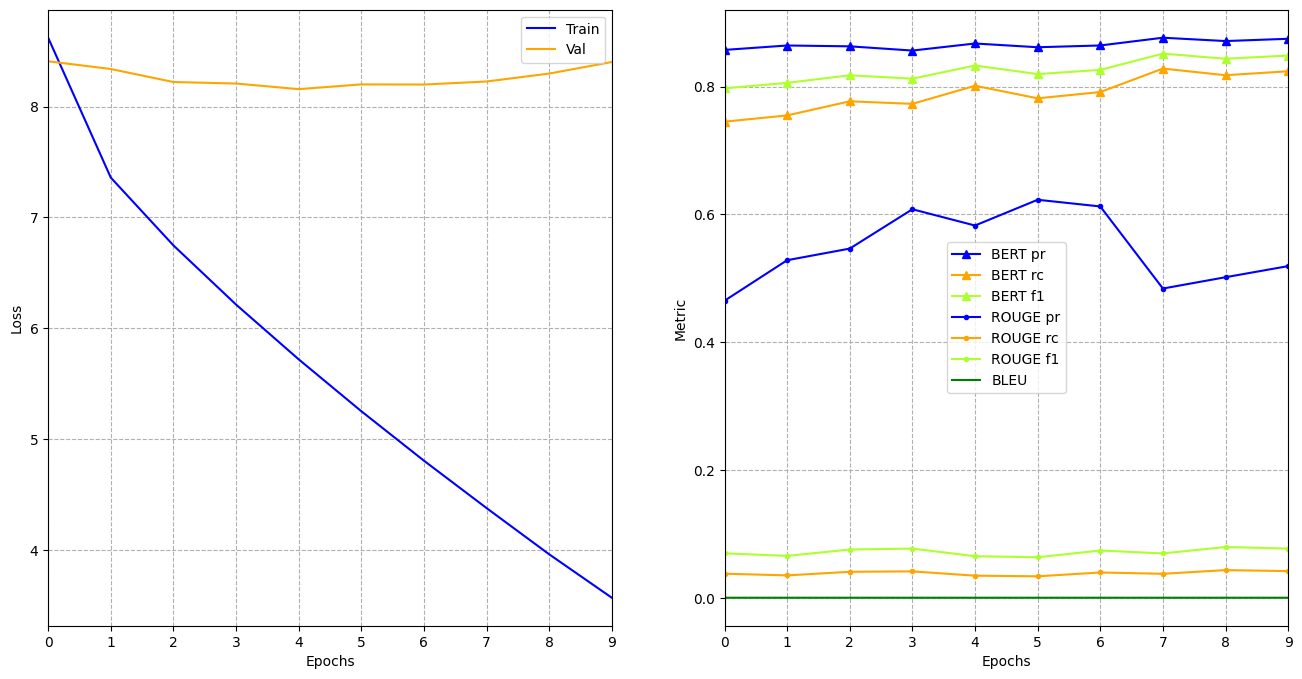

In [17]:
trainer.plot_results()

Для примеров генерации возьмем модель, которая обучалась 10 эпох на 100% данных, с BERT'ом от DeepPavlov ('DeepPavlov/rubert-base-cased'). Возьмем последнюю эпоху, пятую, когда валидационный лосс еще падал, тоесть до переобучения.

In [30]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [31]:
model = BertSummarizer(bert_model_name=model_name)
model.load_state_dict(torch.load('models/2024-10-04_02:33:25.861947/checkpoint#4.pth', weights_only=True))
model = model.to('cuda')
model.eval()

tokenizer = tokenizer.from_pretrained('./tokenizer_dp_100')

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [32]:
eval_data_sample = next(iter(eval_dataloader))
txts = model.generate(eval_data_sample['text']['input_ids'].to('cuda'), eval_data_sample['text']['attention_mask'].to('cuda'), max_len=128, tokenizer=tokenizer)

for i in range(len(txts)):
    print('Original summary:\n')
    print(tokenizer.decode(eval_data_sample['summary']['input_ids'][i], skip_special_tokens=True).replace(' ##', ''), '\n')
    print('Generated summary:\n')
    print(txts[i], '\n')
    print('#'*200, '\n')

Original summary:

В МИД России предлагают зафиксировать « ошибку » в заявлении Пентагона о невыводе американских войск из Ирака. По словам официального представителя ведомства Марии Захаровой, в противном случае США могут « начать кивать на русских хакеров или RT ». Ранее Штаты объяснили, что не собираются уходить из Ирака — вопреки решению парламента страны. 

Generated summary:

Официальный представитель МИД России Мария Захарова заявила, что президент США Дональд Трамп « ошибит », чтобы « не допустить », а также заявил, что Вашингтон готов « русский народ ». По словам представителя МИД РФ Мария Захарова, это не было сделано в рамках « глупой ». 

######################################################################################################################################################################################################## 

Original summary:

Почти для половины россиян 31 декабря стал выходным днем. Таким образом новогодние каникулы у многих увеличились до дев

## Реализация менее жадных стратегий выбора следующего токена (4 балла)
Всегда ли выбор наиболее вероятного токена на каждом шаге – это лучшая стратегия для генерации текста?

<details>
    <summary>Спойлер</summary>
    <p>Нет</p>
</details>

**Сравнение стратегий для генерации текста:**

| Strategy | Description | Pros & Cons |
| --- | --- | --- |
| Greedy Search | Chooses the word with the highest probability as the next word in the sequence. | **Pros:** Simple and fast. <br><br/> **Cons:** Can lead to repetitive and incoherent text. |
| Sampling with Temperature | Introduces randomness in the word selection. A higher temperature leads to more randomness. | **Pros:** Allows exploration and diverse output. <br><br/> **Cons:** Higher temperatures can lead to nonsensical outputs. |
| Nucleus Sampling (Top-p Sampling) | Selects the next word from a truncated vocabulary, the "nucleus" of words <br/> that have a cumulative probability exceeding a pre-specified threshold (p). | **Pros:** Balances diversity and quality. <br><br/> **Cons:** Setting an optimal 'p' can be tricky. |
| Beam Search | Explores multiple hypotheses (sequences of words) at each step, and keeps <br/> the 'k' most likely, where 'k' is the beam width. | **Pros:** Produces more reliable results than greedy search. <br><br/> **Cons:** Can lack diversity and lead to generic responses. |
| Top-k Sampling | Randomly selects the next word from the top 'k' words with the highest probabilities. | **Pros:** Introduces randomness, increasing output diversity. <br><br/> **Cons:** Random selection can sometimes lead to less coherent outputs. |
| Length Normalization | Prevents the model from favoring shorter sequences by dividing the log probabilities <br/> by the sequence length raised to some power. | **Pros:** Makes longer and potentially more informative sequences more likely. <br><br/> **Cons:** Tuning the normalization factor can be difficult. |
| Stochastic Beam Search | Introduces randomness into the selection process of the 'k' hypotheses in beam search. | **Pros:** Increases diversity in the generated text. <br><br/> **Cons:** The trade-off between diversity and quality can be tricky to manage. |
| Decoding with Minimum Bayes Risk (MBR) | Chooses the hypothesis (out of many) that minimizes expected loss under a loss function. | **Pros:** Optimizes the output according to a specific loss function. <br><br/> **Cons:** Computationally more complex and requires a good loss function. |

Ссылки на докуметацию:
- [reference for `AutoModelForCausalLM.generate()`](https://huggingface.co/docs/transformers/v4.29.1/en/main_classes/text_generation#transformers.GenerationMixin.generate)
- [reference for `AutoTokenizer.decode()`](https://huggingface.co/docs/transformers/main_classes/tokenizer#transformers.PreTrainedTokenizer.decode)
- Huggingface [docs on generation strategies](https://huggingface.co/docs/transformers/generation_strategies)

**1. Дополните метод `generate` в модели, чтобы получать топ-k самых вероятных токена и их "вероятности"** (1 балл).   

**2. Реализуйте стратегию Nucleus Sampling в методе `generate`** (1 балл)

**3. Реализуйте стратегию Beam Search** (2 балла)

Получилось ли улучшить генерацию?

Если и получилось, то не занчительно. Методы top-k и top-p действительно в некоторых случаях способствуют генерации более складных текстов, но это все еще похоже на шизофрению.

Большие надежды я возлагал на beam search, но кажется я некорректно его реализовал. Например, в случае если луч сгенерировал конец последовательности, то далее вероятность этого луча не будет уменьшаться, в то время как вероятность других лучей будет (я умножаю вероятности луча на вероятность следующего токена в нем, так что она всегда падает, может это неверно?). Таким образом генериться будет всегда самая короткая последовательность. Для обхода этой проблемы я добавил константную вероятность, которая будет умножаться на вероятность луча в случае, если сгенерировался конец последовательности. Это помогло, текст стал гораздо более осмысленным, но до чего-то адекватного все равно далеко.

In [33]:
eval_data_sample = next(iter(eval_dataloader))

**Top-k генерация**

In [34]:
method = 'topk5'

for i in range(3):
    print('Original summary:\n')
    os = tokenizer.decode(eval_data_sample['summary']['input_ids'][i], skip_special_tokens=True).replace(' ##', '')
    print(os, '\n')
    print('Generated summary:\n')
    gs = model.generate(eval_data_sample['text']['input_ids'][i:i+1].to('cuda'), eval_data_sample['text']['attention_mask'][i:i+1].to('cuda'), method=method, max_len=128, tokenizer=tokenizer)
    print(gs[0], '\n')
    print('#'*200, '\n')

Original summary:

Британская академия кино и телевизионных искусств внесет изменения в принцип отбора лауреатов и номинантов BAFTA — об этом в организации заявили на фоне скандала, разгоревшегося после того, как в шорт - листы премии 2020 года не попали темнокожие актеры и женщины - режиссеры. Комментируя ситуацию, автор « Верности » Нигина Сайфуллаева призналась, что не чувствует подобной дискриминации в российском киносообществе, а народный артист России Владимир Хотиненко выделил необходимость оценивать фильмы по их качеству, а не по каким - то иным критериям. 

Generated summary:

Объявленный « Оскара : британскоеов - 2016 в центре в Голливуде, имена которых оказались в списке лауреатов награды, которые пройдут на премию Британской. Среди других кандидатов и фильм о несчастных номинаций, среди которых не вошли. По данным авторов рейтинга ФИДЕ « Оскара - 2018 / », а в « Оскар в живых в Лондоне. », где будет официально разрешены « Лучший из - на ». По их числе фаворитов », а в ленте

**Top-p генерация**

In [35]:
method = 'topp3'

for i in range(3):
    print('Original summary:\n')
    os = tokenizer.decode(eval_data_sample['summary']['input_ids'][i], skip_special_tokens=True).replace(' ##', '')
    print(os, '\n')
    print('Generated summary:\n')
    gs = model.generate(eval_data_sample['text']['input_ids'][i:i+1].to('cuda'), eval_data_sample['text']['attention_mask'][i:i+1].to('cuda'), method=method, max_len=128, tokenizer=tokenizer)
    print(gs[0], '\n')
    print('#'*200, '\n')

Original summary:

Британская академия кино и телевизионных искусств внесет изменения в принцип отбора лауреатов и номинантов BAFTA — об этом в организации заявили на фоне скандала, разгоревшегося после того, как в шорт - листы премии 2020 года не попали темнокожие актеры и женщины - режиссеры. Комментируя ситуацию, автор « Верности » Нигина Сайфуллаева призналась, что не чувствует подобной дискриминации в российском киносообществе, а народный артист России Владимир Хотиненко выделил необходимость оценивать фильмы по их качеству, а не по каким - то иным критериям. 

Generated summary:

Британская академия академия кинематографических искусств и кино, которые пройдут в Лондоне, в Лондоне, примут участие в церемонии вручения премий BAFTA. Среди претендентов на награду за награды достались мэтра.ы назвали « Лучший фильм »., а также в других номинациях, включая « Оскар ». не оказалось, что в этом году не хватило бы не только в будущем.м., но и в других номинациях, но и в других номинациях.

**Beam search генерация**

In [36]:
txts = model.generate_beamsearch(eval_data_sample['text']['input_ids'][i:i+1].to('cuda'), eval_data_sample['text']['attention_mask'][i:i+1].to('cuda'), beam_width=3, max_len=128, tokenizer=tokenizer)

for i in range(3):
    print('Original summary:\n')
    os = tokenizer.decode(eval_data_sample['summary']['input_ids'][i], skip_special_tokens=True).replace(' ##', '')
    print(os, '\n')
    print('Generated summary:\n')
    gs = model.generate_beamsearch(eval_data_sample['text']['input_ids'][i:i+1].to('cuda'), eval_data_sample['text']['attention_mask'][i:i+1].to('cuda'), beam_width=3, max_len=128, tokenizer=tokenizer)
    print(gs, '\n')
    print('#'*200, '\n')

Original summary:

Британская академия кино и телевизионных искусств внесет изменения в принцип отбора лауреатов и номинантов BAFTA — об этом в организации заявили на фоне скандала, разгоревшегося после того, как в шорт - листы премии 2020 года не попали темнокожие актеры и женщины - режиссеры. Комментируя ситуацию, автор « Верности » Нигина Сайфуллаева призналась, что не чувствует подобной дискриминации в российском киносообществе, а народный артист России Владимир Хотиненко выделил необходимость оценивать фильмы по их качеству, а не по каким - то иным критериям. 

Generated summary:

Объявлены претенденты на премию « Оскар » в Лондоне, в котором примут участие в церемонии вручения премий BAFTA. Среди претендентов на премию « Оскар », « Оскар » и « Оскар », а также « Лучший режиссер » и « Лучший режиссер ». 

##################################################################################################################################################################################

## Послевкусие (0 баллов)

Если эта домашняя работа показалась вам недостаточно большой, предлагаем провести следующий эксперимент:

- от имеющейся модели "откусить" только декодерную часть (откусить также можно от ruT5-small);
- немного дообучить (что называется, по вкусу);
- посмотреть качество генерации по метрикам и "глазами";
- сравнить полученное с Encoder-Decoder архитектурой;
- ответить на вопрос "Дает ли применение Encoder-Decoder архитектуры значительный буст в качестве генерации, или это некоторый overkill?" (базово, ответ лежит на поверхности 😸)

Ещё более опционально можно:
- почитать про возможности генерации Encoder-only архитектурными решениями (BERT, e.g.)
- сравнить с генерацией только Decoder'ом и both Encoder-Decoder'ом;
- в т.ч. подобрать число обучаемых параметров таким образом, чтоб оно было примерно одинаковым для каждого инстанса моделей (их, инстансов, будет 3 -- только энкодер, только декодер и энкодер-декодер).

*Вообще ориентироваться следует на следующее утверждение: "Только энкодерные архитектуры (BERT, e.g.) хороши для понимания текста (получения эмеддингов), лишь декодерные (GPT, например) -- для генерации, энкодер-декодерные (скажем, T5) -- для обеих задач"*